<a href="https://colab.research.google.com/github/MarjeteV/data620/blob/main/Project_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2

Instructions

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?

Group (The DataDriven Team): Susanna Wong, Puja Roy, Mikhail Broomes & Marjete Vucinaj, Danny & Mohammed Rahman

Video : https://drive.google.com/file/d/1S9e1K5TDRr6f52v3iB6StbIGbLVf97WM/view?usp=sharing

In [ ]:
import csv
import pandas as pd
import requests
import io
import networkx as nx
import math
import community
import numpy as np
import networkx.algorithms.bipartite as bi
import matplotlib.pyplot as plt
%matplotlib inline





The dataset from MovieLens includes 5-star ratings and free-text tags for movies; obtained from [kaggle](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset/data). It contains 100,836 ratings and 3,683 tag applications, or genres,  across 9,742 movies. 610 different users contributed their ratings and tags to the dataset between March 29, 1996, and September 24, 2018. The dataset randomly selected users who had rated at least 20 movies, with no demographic information included.

Users are represented by an ID only. The data files are links.csv, movies.csv, ratings.csv, and tags.csv.

In [ ]:
links = pd.read_csv("https://raw.githubusercontent.com/MAB592/Data620/main/Assignments/Project%202/links.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/MAB592/Data620/main/Assignments/Project%202/movies.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/MAB592/Data620/main/Assignments/Project%202/ratings.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/MAB592/Data620/main/Assignments/Project%202/tags.csv")

In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Join ratings and movies dataframes, join mov_rat with tags dataframe, and join mov_rat_tag with links dataframe. To differentiate columns with the same name in the joined dataframe rsuffix='_links' is used and then the result is assigned to df.

In [ ]:
mov_rat = ratings.join(movies, on='movieId', how='inner', lsuffix='_ratings', rsuffix='_movies')

mov_rat_tag = mov_rat.join(tags, on='movieId', how='inner', rsuffix='_tags')

final_df = mov_rat_tag.join(links, on='movieId', how='inner', rsuffix='_links')

df = final_df

df.head()

,movieId,userId,movieId_ratings,rating,timestamp,movieId_movies,title,genres,userId_tags,movieId_tags,tag,timestamp_tags,movieId_links,imdbId,tmdbId
0,1,1,1,4.0,964982703,2,Jumanji (1995),Adventure|Children|Fantasy,2,60756,Highly quotable,1445714996,2,113497,8844.0
516,1,5,1,4.0,847434962,2,Jumanji (1995),Adventure|Children|Fantasy,2,60756,Highly quotable,1445714996,2,113497,8844.0
874,1,7,1,4.5,1106635946,2,Jumanji (1995),Adventure|Children|Fantasy,2,60756,Highly quotable,1445714996,2,113497,8844.0
1434,1,15,1,2.5,1510577970,2,Jumanji (1995),Adventure|Children|Fantasy,2,60756,Highly quotable,1445714996,2,113497,8844.0
1667,1,17,1,4.5,1305696483,2,Jumanji (1995),Adventure|Children|Fantasy,2,60756,Highly quotable,1445714996,2,113497,8844.0


The summary on kaggle about the dataset (above) might have respresented their intial finding before they randomly filtered it to select users who had rated at least 20 movies.

The summary statistics indicate that the current analysis is based on 56,300 ratings(not 100,836) across 3,682 movies (not 9,742). The ratings distribution ranges between 0-5 as expected.

In [ ]:
summary_stats = df[['userId', 'movieId', 'rating']].describe()

print(summary_stats)

             userId       movieId        rating
count  56300.000000  56300.000000  56300.000000
mean     320.372309   1463.865808      3.535089
std      184.671400   1044.273718      1.052672
min        1.000000      1.000000      0.500000
25%      167.000000    524.000000      3.000000
50%      316.000000   1259.000000      4.000000
75%      474.000000   2329.000000      4.000000
max      610.000000   3682.000000      5.000000


Initialize Graph, add nodes for users and to indicate that these nodes belong to the first partite set use bipartite=0. Add nodes for movies and use bipartite=1 so nodes belong to the second partite set.

In [ ]:
G = nx.Graph()
G.add_nodes_from(df['userId'].unique(), bipartite=0)
G.add_nodes_from(df['movieId'].unique(), bipartite=1)

Iterate through dataframe rows, and add edges to the graph.



In [ ]:
edges = [(row['userId'], row['movieId']) for idx, row in df.iterrows()]
G.add_edges_from(edges)

Set up the figure size, create the layout for nodes, and draw  the bipartite graph including titles and labels. This visualization shows the relationships between users (userId) and movies (movieID) in the dataset.

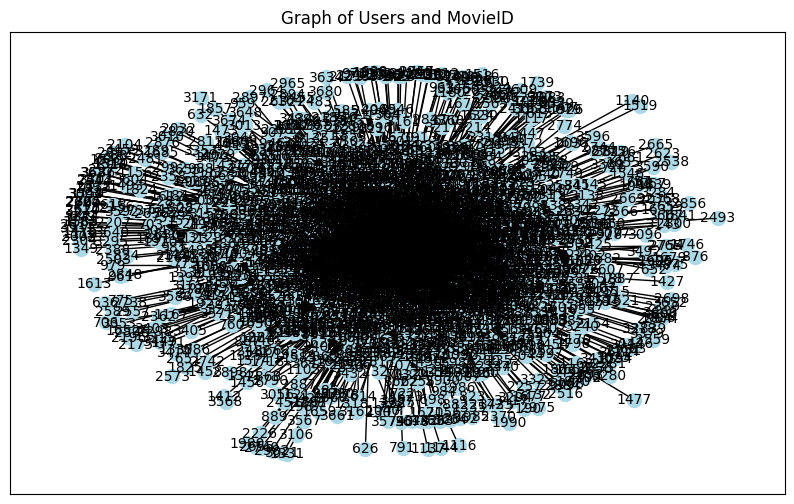

In [ ]:
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=100, font_size=10)
plt.title('Graph of Users and MovieID')
plt.show()

Create a network of users (nodes), green, based on their interactions(edges) with movies. Filter to include only the largest connected component of users. Use logarithm of interaction counts, which iterates through each edge, to visualize strength of connection or edges.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


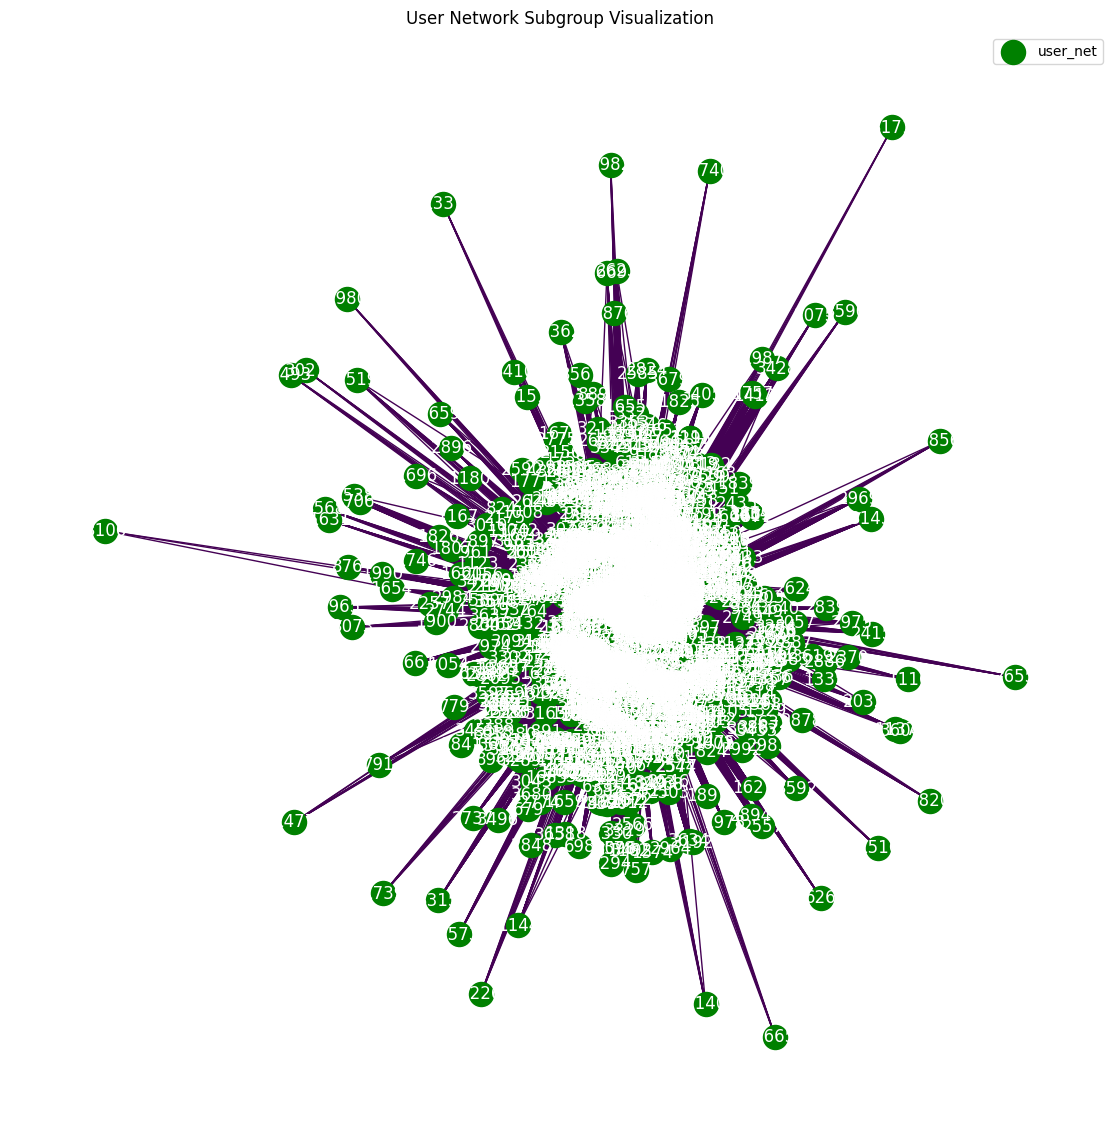

In [ ]:
user_net = nx.bipartite.weighted_projected_graph(G, df['userId'].unique())

largest_component = max(nx.connected_components(user_net), key=len)
user_net = user_net.subgraph(largest_component).copy()

weights = [math.log(edata['weight']) for u, v, edata in user_net.edges(data=True)]

plt.figure(figsize=(11, 11))
pos = nx.spring_layout(user_net)
nx.draw(user_net, pos, node_color='g', with_labels=True, node_size=300, font_color='w', edge_color=weights, cmap=plt.cm.Blues)
plt.title('User Network Subgroup Visualization')
plt.legend(["user_net"])
plt.show()

User_net represents a network of users where edges represent shared movie ratings totalling 2828.

In [ ]:
len(user_net)

2828

Create a network of movie nodes, creating a new graph where an edge exists between two movies if they have been rated by the same user(s). It visualizes the largest connected component of this network, using the logarithm of the number of shared ratings for edge weights to highlight how movies are linked through user interactions.


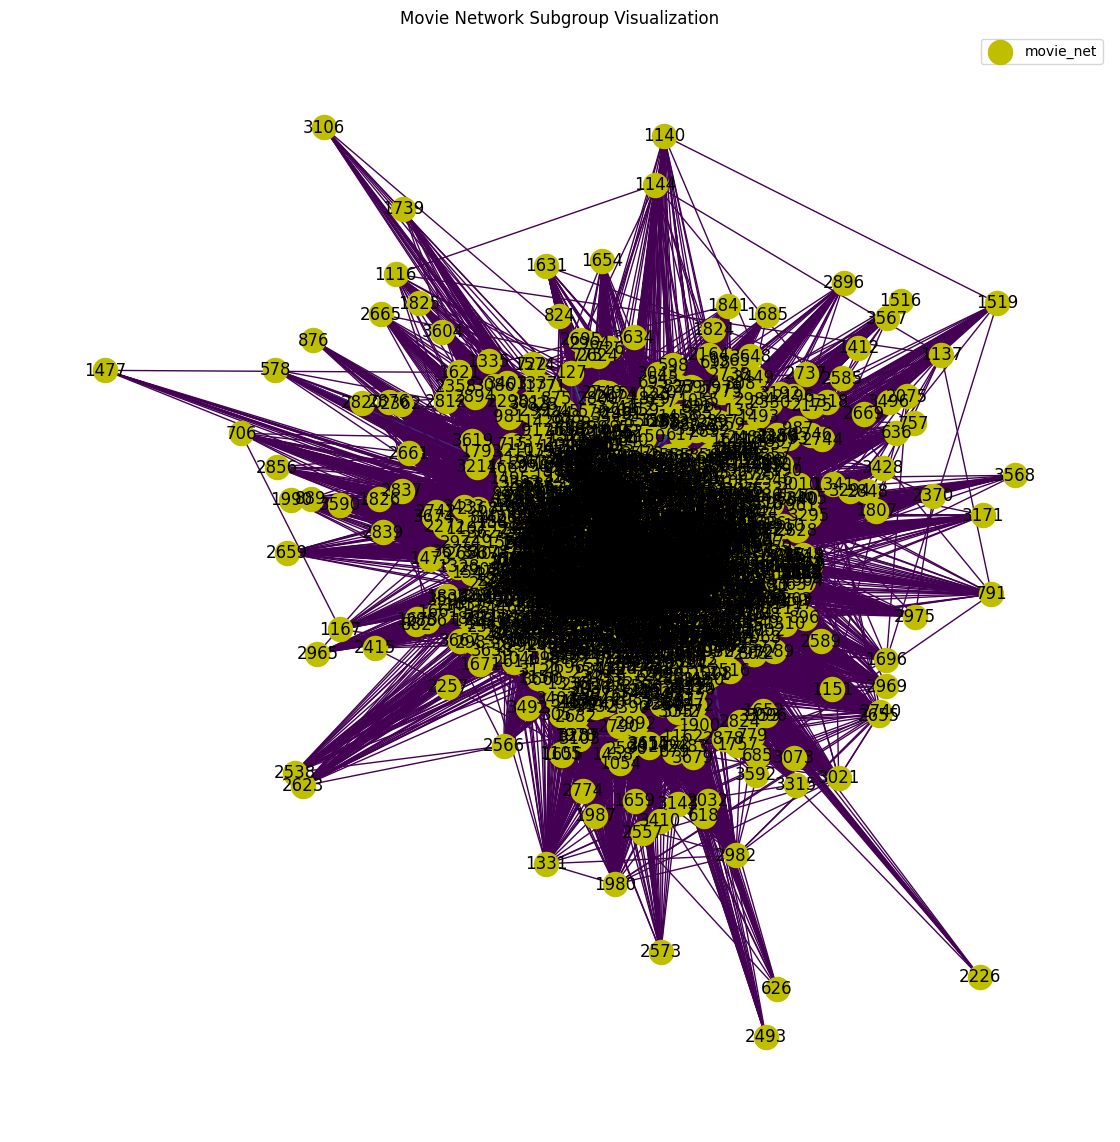

In [ ]:
movie_net = nx.bipartite.weighted_projected_graph(G, df['movieId'].unique())

largest_component = max(nx.connected_components(movie_net), key=len)
movie_net = movie_net.subgraph(largest_component).copy()

weights = [math.log(edata['weight']) for u, v, edata in movie_net.edges(data=True)]

plt.figure(figsize=(11, 11))
pos = nx.spring_layout(movie_net)
nx.draw(movie_net, pos, node_color='y', with_labels=True, node_size=300, font_color='k', edge_color=weights, cmap=plt.cm.Blues)
plt.title('Movie Network Subgroup Visualization')
plt.legend(["movie_net"])
plt.show()


Find the number of unique movies in the largest connected component of the movie network, equaling user_net since they are derived from the same bipartite graph G

In [ ]:
len(movie_net)

2828


Create simplified graph, g2, by using the trim function to remove edges based on specified weight threshold.

In [ ]:
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            g2.add_edge(f,to,**edata)
    return g2

Visualize the trim movie_net, g2, where edges with weights less than or equal to 2.69 are removed (or exp .99). Edges represent shared movie ratings between users, with edge weights indicating the number of movies they have rated in common.

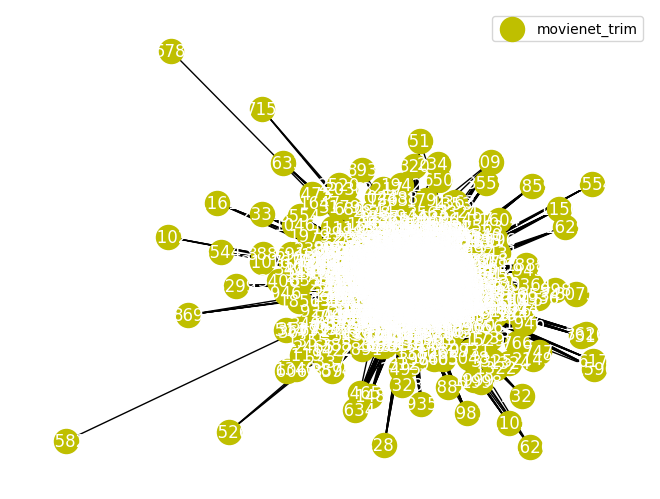

In [ ]:
movienet_trim = trim_edges(movie_net, weight=math.exp(0.99))
weights = [edata['weight'] for f,t,edata in movienet_trim.edges(data=True)]

nx.draw_spring(movienet_trim, label = 'movienet_trim', node_color='y',with_labels=True,node_size =300,font_color ='w')
plt.legend(["movienet_trim"])
plt.show()

In [ ]:
len(movienet_trim)

2286

Visualize trimmed user_net. Edges represent shared user ratings between movies, with edge weights indicating the number of users who have rated both movies.

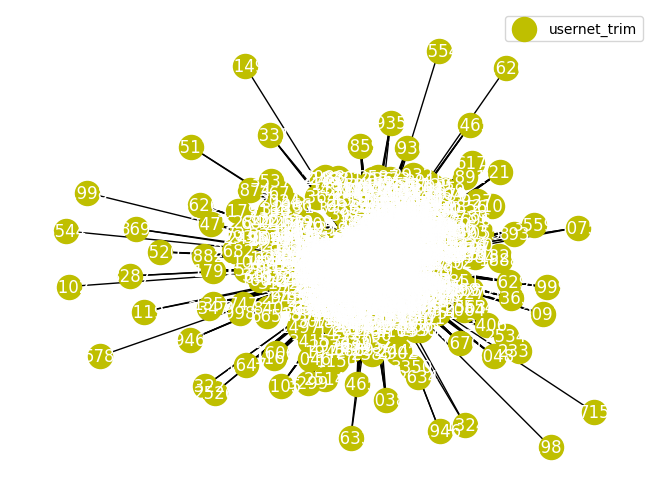

In [ ]:
usernet_trim = trim_edges(user_net, weight=math.exp(0.99))
weights = [edata['weight'] for f,t,edata in usernet_trim.edges(data=True)]

nx.draw_spring(usernet_trim, label = 'usernet_trim', node_color='y',with_labels=True,node_size =300,font_color ='w')
plt.legend(["usernet_trim"])
plt.show()

Length of trimmed movie_net is not equal to trimmed user_net because they reflect different aspects of the user-movie interaction data.

In [ ]:
len(usernet_trim)

2281

Understand the range of edge weights present in the graph by calculating the minimum and maximum edge weights from the movienet_trim graph.

In [ ]:
weights= [edata['weight'] for f,to,edata in movienet_trim.edges(data=True)]
mn = int(min(weights))
mx = int(max(weights))

Use island method where "the giant component gets split up into smaller components, and areas with the strongest amount of ... activity (subcores) become their own components that can be analyzed separately (Social Network Analysis, pg 63)."

In [ ]:
def island_method(movienet_trim, iterations=10):
    step =((mx - mn)/iterations)
    return [[threshold, trim_edges(movienet_trim, threshold)] for threshold in np.arange(mn,mx,step)]

Are the graphs directed?


*   undirected allows for analysis that treats relationships as bidirectional.



In [ ]:
user_ud = usernet_trim.to_undirected()
fb_components = nx.connected_components(user_ud)
nx.is_directed(user_ud)

False

In [ ]:
movie_ud = movienet_trim.to_undirected()
fb_components = nx.connected_components(movie_ud)
nx.is_directed(movie_ud)

False

# Looking at Centrality between the groups

Sorted_map function sorts items in dictionary 'map' based on their values in descending order. If two items have the same value, it sorts them by their keys in ascending order. It returns a list of these sorted key-value pairs.

In [ ]:
def sorted_map(map):
    ms = sorted(map.items(), key=lambda x: (-x[1], x[0]))
    return ms

Degree Centrality for users measures the importance of a user within the network(between 0 and 1). The top 5 users are printed and they have rated more movies compared to others in the dataset and implies they are influential in shaping movie recommendations.


In [ ]:
# Degree Centrality for users
dcent = nx.degree_centrality(user_ud)
dcent_s = sorted(dcent.items(), key=lambda item: item[1], reverse=True)
print(dcent_s[:5])

[(260, 0.9596491228070175), (356, 0.9565789473684211), (608, 0.9508771929824562), (1, 0.9372807017543859), (296, 0.9364035087719298)]


In [ ]:
# Degree Centrality for movieID
dcent2 = nx.degree_centrality(movie_ud)
dcent_s2 = sorted(dcent2.items(), key=lambda item: item[1], reverse=True)
print(dcent_s2[:5])

[(260, 0.9575492341356674), (356, 0.9544857768052517), (608, 0.9487964989059081), (1, 0.9352297592997812), (296, 0.9343544857768052)]


Closeness Centrality refers to the distance to other

In [ ]:
# Closeness Centrality for users
ccent = nx.closeness_centrality(user_ud)
ccent_s = sorted(ccent.items(), key=lambda item: item[1], reverse=True)
print(ccent_s[:5])

[(260, 0.9612141652613828), (356, 0.9583858764186634), (608, 0.9531772575250836), (1, 0.94098225340487), (296, 0.9402061855670103)]


In [ ]:
# Closeness Centrality for MovieID
ccent2 = nx.closeness_centrality(movie_ud)
ccent_s2 = sorted(ccent.items(), key=lambda item: item[1], reverse=True)
print(ccent_s2[:5])

[(260, 0.9612141652613828), (356, 0.9583858764186634), (608, 0.9531772575250836), (1, 0.94098225340487), (296, 0.9402061855670103)]


Betweenness Centrality

In [ ]:
# Betweenness Centrality for Users
bcent = nx.betweenness_centrality(user_ud)
bcent_s = sorted(bcent.items(), key=lambda item: item[1], reverse=True)
print(bcent_s[:5])

[(260, 0.0165739523000926), (356, 0.014786338536565845), (608, 0.013857928967418068), (1, 0.012731266209360955), (296, 0.012703732061049232)]


In [ ]:
# Betweenness Centrality for Movies
bcent2 = nx.betweenness_centrality(movie_ud)
bcent_s2 = sorted(bcent.items(), key=lambda item: item[1], reverse=True)
print(bcent_s2[:5])

[(260, 0.0165739523000926), (356, 0.014786338536565845), (608, 0.013857928967418068), (1, 0.012731266209360955), (296, 0.012703732061049232)]


These additions would explicitly address the questions about dataset selection, network size reduction, and inference about distinct groups within the network. They enhance the analysis by adding community detection and deeper exploration of centrality measures within identified groups.